## First, load the data and make the plots as they match the Jensen and Janes

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import scipy.io
from matplotlib.colors import ListedColormap
import seaborn as sns


# load the colormap 
# This can be used to setup the exact color map
array_map_file = 'arraymap.mat'
array_map = scipy.io.loadmat(array_map_file)
custom_cmap = ListedColormap(array_map['arraymap'])

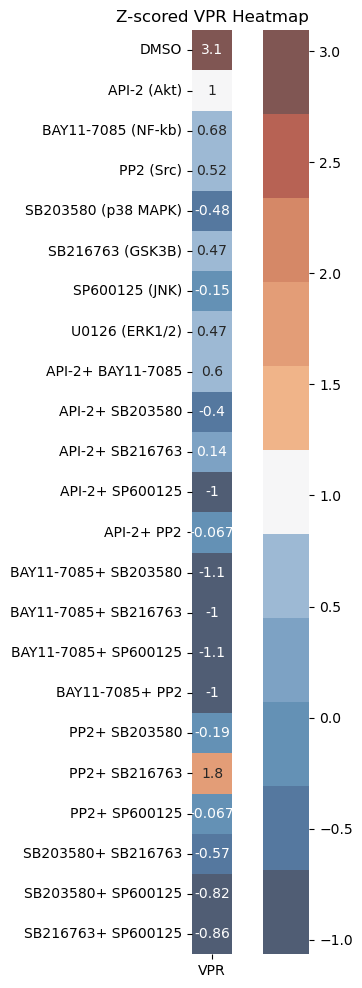

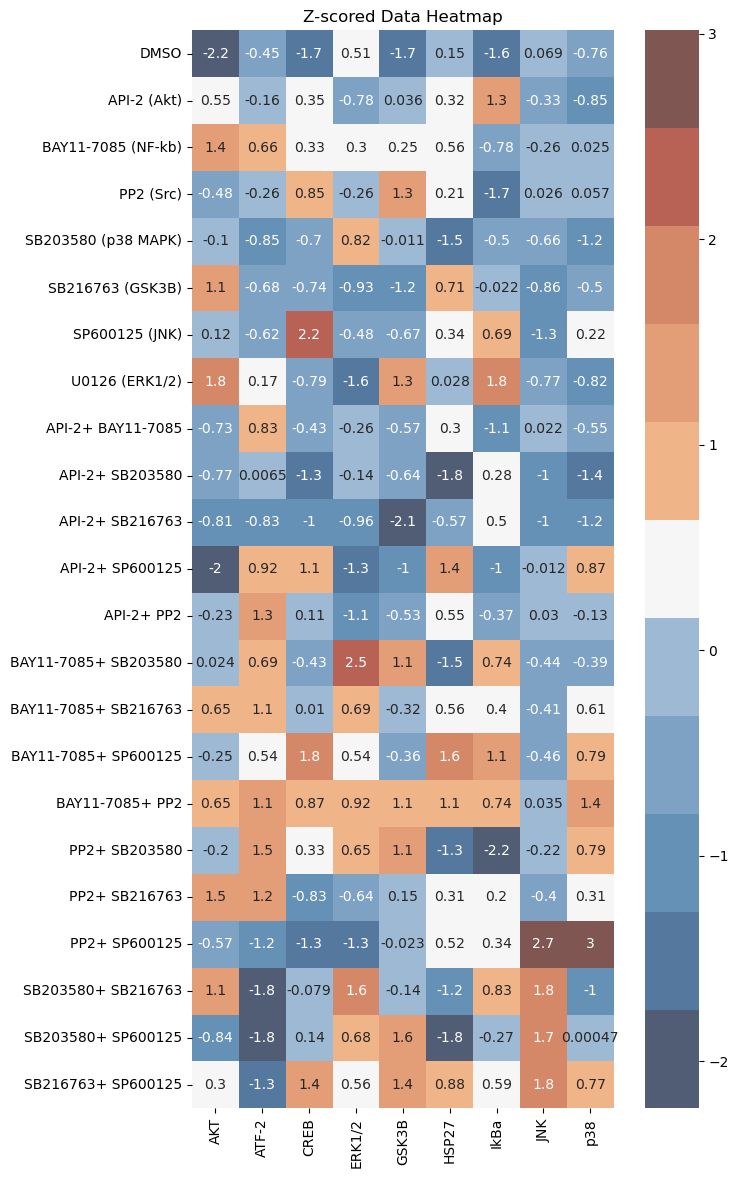

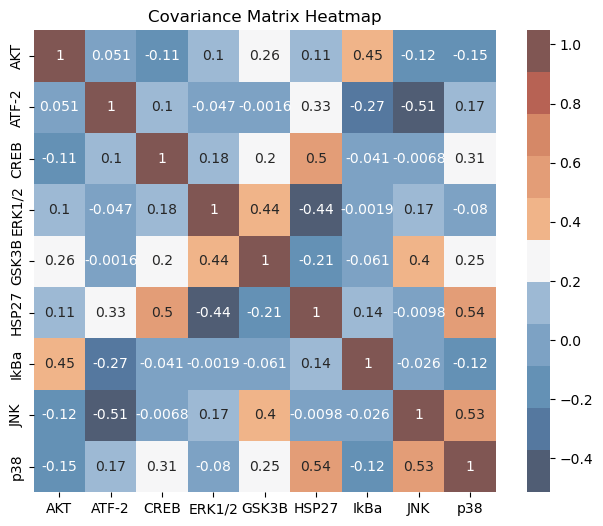

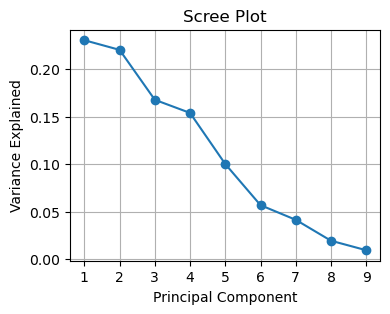

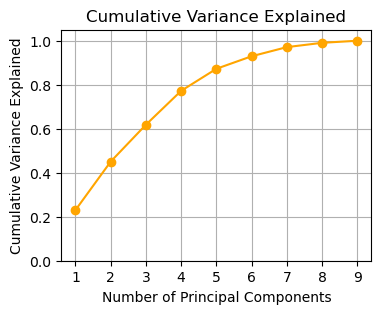

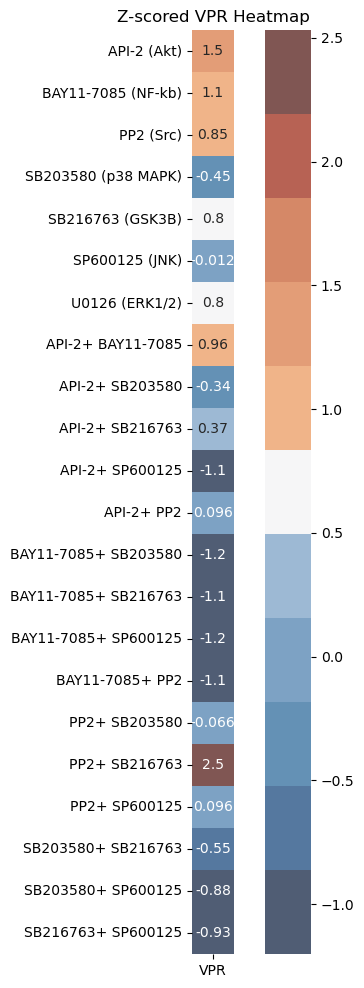

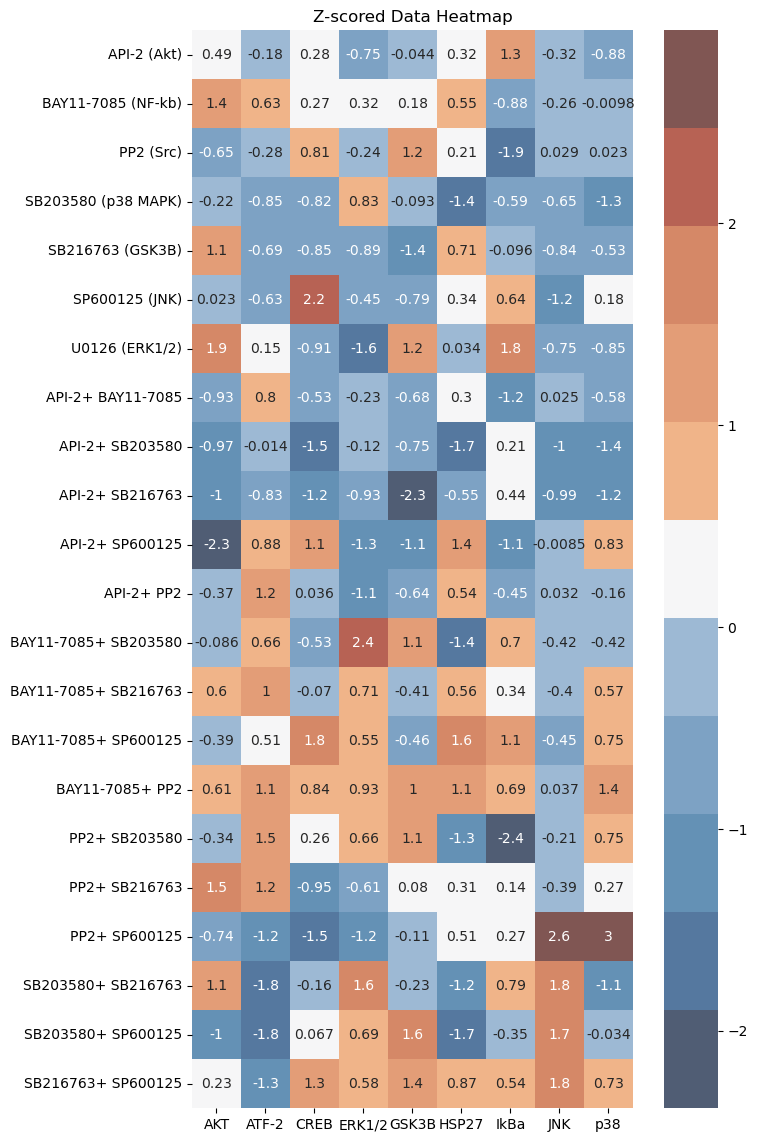

In [7]:
#load the dataframe
data = pd.read_csv('Jensen_Janes_data_integral.csv', index_col=0)
vpr = pd.read_csv('Jensen_Janes_VPR.csv', index_col=0)

#take the zscore of the data and the VPR and plot these.
df_VPR_zscore = vpr.apply(stats.zscore, axis=0, nan_policy='omit')
df_data_zscore = data.apply(stats.zscore, axis=0, nan_policy='omit')



plot_data_heatmap(df_data_zscore, df_VPR_zscore, custom_cmap)

# Remove the DMSO control and perform PCA
data_sub = data.drop(index=['DMSO'])
vpr_sub = vpr.drop(index=['DMSO'])
df_data_sub_zscore = data_sub.apply(stats.zscore, axis=0, nan_policy='omit')
df_vpr_sub_zscore = vpr_sub.apply(stats.zscore, axis=0, nan_policy='omit')
eigval, eigvec = pca_by_eig(df_data_sub_zscore, custom_cmap)


plot_data_heatmap(df_data_sub_zscore, df_vpr_sub_zscore, custom_cmap)


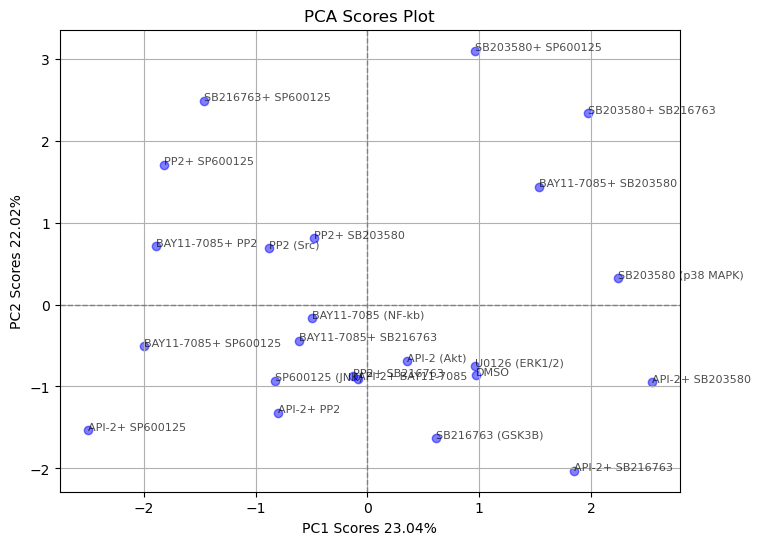

In [8]:
# Let's plot the scores (The transformed data into the PC space)
#Calculate the scores by matrix multiplication of the zscore data and the eigenvectors
T = np.matmul(df_data_zscore.values, eigvec)
# plot the first two dimensions of T, the scores
plt.figure(figsize=(8, 6))
plt.scatter(T[:, 0], T[:, 1], c='blue', alpha=0.5)
# annotate the points with the row labels from the original data
for i, txt in enumerate(df_data_zscore.index):
    plt.annotate(txt, (T[i, 0], T[i, 1]), fontsize=8, alpha=0.7)    
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.axvline(0, color='gray', linestyle='--', linewidth=1)
plt.xlabel('PC1 Scores %0.2f%%' % (eigval[0]/np.sum(eigval)*100))
plt.ylabel('PC2 Scores %0.2f%%' % (eigval[1]/np.sum(eigval)*100))
plt.title('PCA Scores Plot')
plt.grid()
plt.show()


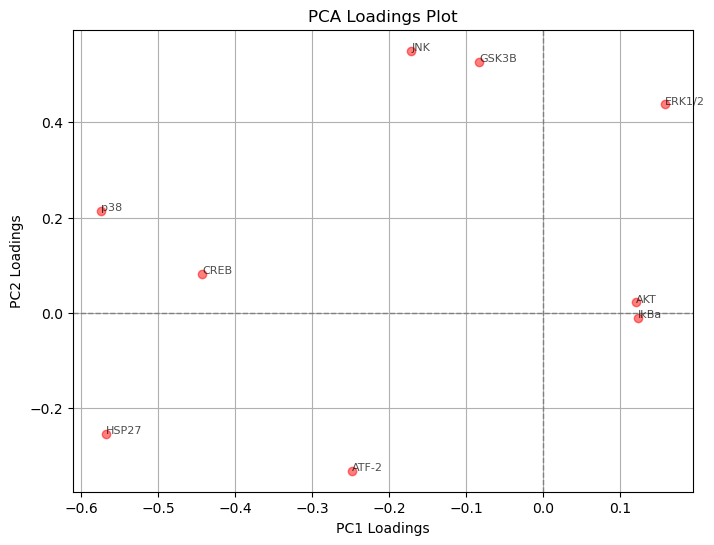

In [9]:
# Plot the first two principal components weights or loadings (eigenvectors)
plt.figure(figsize=(8, 6))
plt.scatter(eigvec[:, 0], eigvec[:, 1], c='red', alpha=0.5)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.axvline(0, color='gray', linestyle='--', linewidth=1)
# annotate the points with the column labels from the original data
for i, txt in enumerate(df_data_zscore.columns):
    plt.annotate(txt, (eigvec[i, 0], eigvec[i, 1]), fontsize=8, alpha=0.7)
plt.xlabel('PC1 Loadings')
plt.ylabel('PC2 Loadings')
plt.title('PCA Loadings Plot')
plt.grid()
plt.show()

In [3]:
def plot_data_heatmap(data, y, cmap):
    # Display the zscored data with a heatmap (in the data frame), here picking a color scheme that approximates that used
    # by Jensen and Janes
    # Put the VPR data on a subplot
    plt.figure(figsize=(8, 12))
    sns.heatmap(y, annot=True, cmap=cmap, square=True)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.title('Z-scored VPR Heatmap')
    plt.show()  
    plt.figure(figsize=(8, 14))
    sns.heatmap(data, annot=True, cmap=cmap, square=True)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.title('Z-scored Data Heatmap')
    plt.show() 



In [4]:
def pca_by_eig(data, custom_cmap):
    """
    Perform PCA on the given dataset and plot the covariance matrix heatmap,
    scree plot, and cumulative variance explained plot.
    Parameters:
    data (pd.DataFrame): The input dataset where rows are samples and columns are features.
    Returns:
    eigVals (np.ndarray): The sorted eigenvalues.
    eigVec (np.ndarray): The corresponding sorted eigenvectors.

    """

    S = data.cov()
    plt.figure(figsize=(8, 6))
    sns.heatmap(S, annot=True, cmap=custom_cmap, square=True)
    plt.title('Covariance Matrix Heatmap')
    plt.show()

    eigVals, eigVec = np.linalg.eig(S)

    # sort the eigenvalues in descending order, use the same for the sorted eigenvectors
    sorted_indices = np.argsort(eigVals)[::-1]
    eigVals = eigVals[sorted_indices]
    eigVec = eigVec[:, sorted_indices]

    # make some plots of variance described
    var_explained = eigVals / np.sum(eigVals)
    plt.figure(figsize=(4, 3))
    plt.plot(range(1, len(var_explained) + 1), var_explained, marker='o')
    plt.title('Scree Plot')
    plt.xlabel('Principal Component')
    plt.ylabel('Variance Explained')
    plt.xticks(range(1, len(var_explained) + 1))
    plt.grid()
    plt.show()

    # Make the cumulative variance explained plot
    cum_var_explained = np.cumsum(var_explained)
    plt.figure(figsize=(4, 3))
    plt.plot(range(1, len(cum_var_explained) + 1), cum_var_explained, marker='o', color='orange')
    plt.title('Cumulative Variance Explained')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Variance Explained')
    plt.xticks(range(1, len(cum_var_explained) + 1))
    plt.ylim(0, 1.05)
    plt.grid()
    plt.show()  

    return eigVals, eigVec

## PCA using sklearn

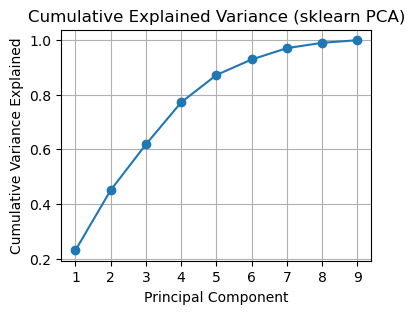

In [10]:
from sklearn.decomposition import PCA
# will need scikit-learn 

## PCA using sklearn
pca_model = PCA()
pca_model.fit(df_data_sub_zscore)
T_sklearn = pca_model.transform(df_data_sub_zscore)
explained_variance = pca_model.explained_variance_
explained_variance_ratio = pca_model.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
# Plot cumulative explained variance 
plt.figure(figsize=(4, 3))
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o')
plt.title('Cumulative Explained Variance (sklearn PCA)')
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Variance Explained')
plt.xticks(range(1, len(explained_variance_ratio) + 1))
plt.grid()
plt.show()  



In [11]:
explained_variance_ratio

array([0.23038702, 0.22023826, 0.16773909, 0.15392788, 0.10017386,
       0.05692903, 0.04152886, 0.0195364 , 0.0095396 ])

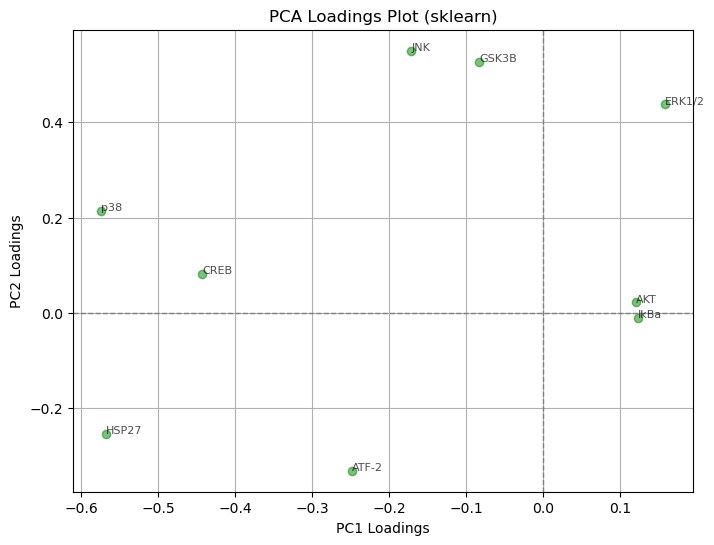

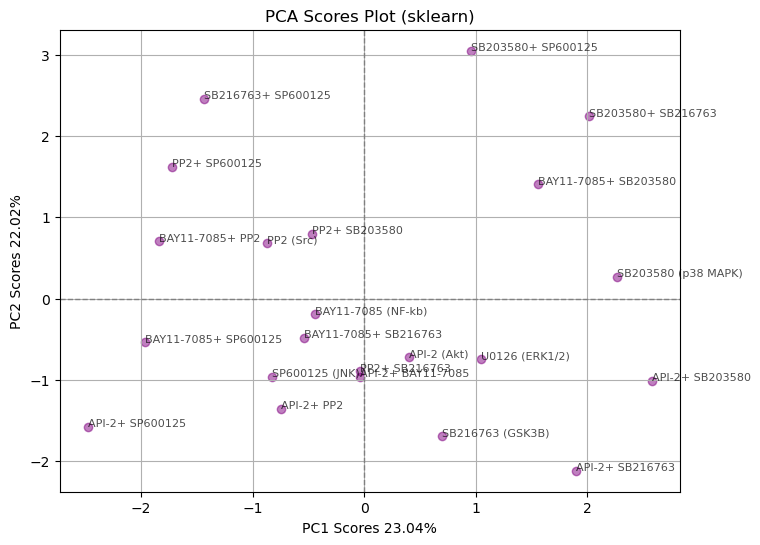

In [12]:
pca_model.components_.shape  # shape should be (n_components, n_features)

#plot the loadings
plt.figure(figsize=(8, 6))
plt.scatter(pca_model.components_[0, :], pca_model.components_[1, :], c='green', alpha=0.5)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.axvline(0, color='gray', linestyle='--', linewidth=1)
# annotate the points with the column labels from the original data
for i, txt in enumerate(df_data_sub_zscore.columns):
    plt.annotate(txt, (pca_model.components_[0, i], pca_model.components_[1, i]), fontsize=8, alpha=0.7)
plt.xlabel('PC1 Loadings')
plt.ylabel('PC2 Loadings')
plt.title('PCA Loadings Plot (sklearn)')
plt.grid()
plt.show()  

# plot the scores
plt.figure(figsize=(8, 6))
plt.scatter(T_sklearn[:, 0], T_sklearn[:, 1], c='purple', alpha=0.5)
# annotate the points with the row labels from the original data
for i, txt in enumerate(df_data_sub_zscore.index):
    plt.annotate(txt, (T_sklearn[i, 0], T_sklearn[i, 1]), fontsize=8, alpha=0.7)            
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.axvline(0, color='gray', linestyle='--', linewidth=1)
plt.xlabel('PC1 Scores %0.2f%%' % (explained_variance_ratio[0]*100))
plt.ylabel('PC2 Scores %0.2f%%' % (explained_variance_ratio[1]*100))
plt.title('PCA Scores Plot (sklearn)')
plt.grid()
plt.show()  

# PLSR 

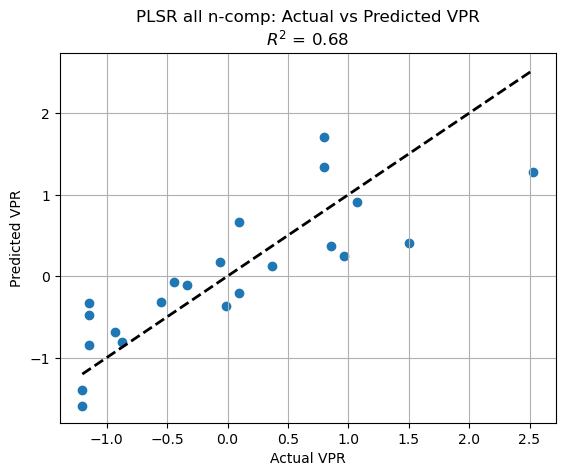

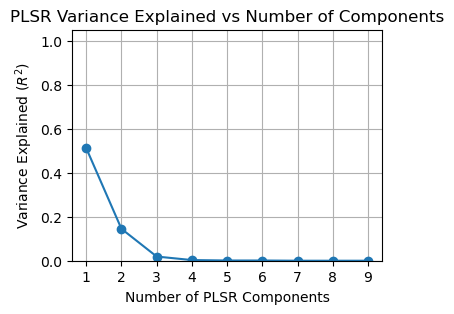

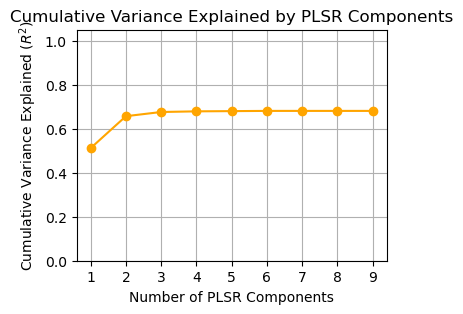

In [40]:
# run a PLSR between vpr_sub and data_sub (both zscored and without DMSO)
from sklearn.cross_decomposition import PLSRegression

X = df_data_sub_zscore
Y = df_vpr_sub_zscore

pls_num_components = X.shape[1]

# first run a model with all components and look at the variance explained
pls_full_model = PLSRegression(n_components=pls_num_components)
pls_full_model.fit(X, Y)




Y_full_pred = pls_full_model.predict(X)
ss_total_full = np.sum((Y.values - np.mean(Y.values))**2)
ss_residual_full = np.sum((Y.values - Y_full_pred)**2)
r_squared_full = 1 - (ss_residual_full / ss_total_full)
plt.scatter(Y, Y_full_pred)

# add a perfect fit line
plt.plot([Y.values.min(), Y.values.max()], [Y.values.min(), Y.values.max()], 'k--', lw=2)
plt.xlabel('Actual VPR')
plt.ylabel('Predicted VPR')
plt.title('PLSR all n-comp: Actual vs Predicted VPR\n$R^2$ = %0.2f' % r_squared_full)
plt.grid()
plt.show()

# This calls a function to calculate the percent variance explained by each component and it will
# plot the scree plots, variance explained and cumulative variance explained
perc_var_explained = plsr_variance_explained(pls_full_model, X, Y)
  



In [39]:
def plsr_variance_explained(pls_model, X, Y):
    """
    Given a fitted PLSRegression model, calculate the variance explained (R^2)
    for the response variable.
    Parameters:
    pls_model (PLSRegression): A fitted PLSRegression model.
    X (pd.DataFrame): The predictor variables used in the model.
    Y (pd.DataFrame): The response variable used in the model.
    Returns:
    perc_var_explained: list of floats, The R^2 value indicating variance explained for each component.
    """
    max_components = pls_model.n_components
    perc_var_explained = []
    for i in range(0,max_components):
        Y_pred2=np.dot(pls_model.x_scores_[:,i].reshape(-1,1),pls_model.y_loadings_[:,i].reshape(-1,1).T)+Y.mean(axis=0)[0]
        perc_var_explained.append(round(r2_score(Y,Y_pred2),3)) 

    plt.figure(figsize=(4, 3))
    plt.plot(range(1, max_components + 1), perc_var_explained, marker='o')
    plt.title('PLSR Variance Explained vs Number of Components')
    plt.xlabel('Number of PLSR Components')
    plt.ylabel('Variance Explained ($R^2$)')
    plt.xticks(range(1, max_components + 1))
    plt.ylim(0, 1.05)
    plt.grid()
    plt.show()

        # plot the cumulative variance explained
    plt.figure(figsize=(4, 3))
    cum_perc_var_explained = np.cumsum(perc_var_explained)
    plt.plot(range(1, pls_num_components + 1), cum_perc_var_explained, marker='o', color='orange')
    plt.title('Cumulative Variance Explained by PLSR Components')
    plt.xlabel('Number of PLSR Components')
    plt.ylabel('Cumulative Variance Explained ($R^2$)')
    plt.xticks(range(1, pls_num_components + 1))
    plt.ylim(0, 1.05)
    plt.grid()
    plt.show()
    return perc_var_explained

In [ ]:
# PLSR with 2 components
pls_model = PLSRegression(n_components=2)
pls_model.fit(df_data_sub_zscore, vpr_sub)
T_pls = pls_model.transform(df_data_sub_zscore)

# variance explained in Y by each PLS component
# plot the predictions versus the actuals
Y_pred = pls_model.predict(df_data_sub_zscore)
ss_total = np.sum((vpr_sub.values - np.mean(vpr_sub.values))**2)
ss_residual = np.sum((vpr_sub.values - Y_pred)**2)
r_squared = 1 - (ss_residual / ss_total)


# measure fitness 
#fitness = 

plt.figure(figsize=(6, 6))
plt.scatter(vpr_sub.values, Y_pred, c='black', alpha=0.5)
plt.xlabel('Actual VPR')
plt.ylabel('Predicted VPR')
plt.title('PLSR: Actual vs Predicted VPR\n$R^2$ = %0.2f' % r_squared)
plt.plot([vpr_sub.values.min(), vpr_sub.values.max()], [vpr_sub.values.min(), vpr_sub.values.max()], 'r--')
plt.grid()
plt.show()


# plot the scores from the PLSR
plt.figure(figsize=(8, 6))
plt.scatter(T_pls[:, 0], T_pls[:, 1], c='brown', alpha=0.5)
# annotate the points with the row labels from the original data
for i, txt in enumerate(df_data_sub_zscore.index):
    plt.annotate(txt, (T_pls[i, 0], T_pls[i, 1]), fontsize=8, alpha=0.7)    
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.axvline(0, color='gray', linestyle='--', linewidth=1)
plt.xlabel('PLS1 Scores')
plt.ylabel('PLS2 Scores')
plt.title('PLSR Scores Plot')
plt.grid()
plt.show()

# plot the loadings
plt.figure(figsize=(8, 6))
plt.scatter(pls_model.x_loadings_[:, 0], pls_model.x_loadings_[:, 1], c='cyan', alpha=0.5)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.axvline(0, color='gray', linestyle='--', linewidth=1)
# annotate the points with the column labels from the original data
for i, txt in enumerate(df_data_sub_zscore.columns):
    plt.annotate(txt, (pls_model.x_loadings_[i, 0], pls_model.x_loadings_[i, 1]), fontsize=8, alpha=0.7)
plt.xlabel('PLS1 Loadings %0.2f%%' % (np.var(T_pls[:, 0])/np.sum(np.var(T_pls))))
plt.ylabel('PLS2 Loadings %0.2f%%' % (np.var(T_pls[:, 1])/np.sum(np.var(T_pls))))
plt.title('PLSR Loadings Plot')
plt.grid()
plt.show()

In [ ]:
Y_pred